# Braille Text Translator

## Objective

Given a picture containing a braille message, the goal of this project is to translate the message into text using image processing techniques to enhance and segment the braille circles, and pattern recognition of the braille blocks

## Test Images
### *1.png*
<img src="https://raw.githubusercontent.com/lucasturci/BrailleTextTranslator/master/media/images/1.png" width="540"  />

### *1.jpg*
<img src="https://raw.githubusercontent.com/lucasturci/BrailleTextTranslator/master/media/images/1.jpg" width="540"  />

## Library imports

In [0]:
import sys
import cv2
import scipy
import random
import imageio
import numpy as np
import zipfile as zf
import matplotlib.pyplot as plt

from scipy import ndimage
from imageio import imread
from skimage.feature import hog
from scipy.ndimage import shift
from skimage.transform import resize
from sklearn.metrics import accuracy_score
from PIL import Image, ImageDraw, ImageFont
from skimage.util import random_noise, invert
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

## 1. Enhance original image

The first step is to enhance the original image using image processing techniques.


1.   Transform RGB image to grayscale
2.   Perform image normalization, to improve contrast
3.   Mean filter to remove some noise



### Function declarations

In [0]:
# Normalizes image pixels between 0 and 255
def normalize(img):
	imin = np.min(img)
	imax = np.max(img)

	return (((img - imin)/(imax - imin)) * 255).astype(np.float)

# Prints image with minimum value equal to 0 and maximum to 255
def printNormalizedImage(img):
	plt.figure(figsize=(16,8)) 
	plt.imshow(img, cmap="gray", vmin=0, vmax=255)
  
# Prints image with matplotlib defaults  
def printImage(img):
	plt.figure(figsize=(16,8)) 
	plt.imshow(img, cmap="gray")

# Median difference filter, highlights the shadow pixels
def Filter(I, n):
	m = n//2
	J = np.empty(I.shape, dtype=np.float)
	N, M = I.shape
	I = np.pad(I, ((m, m), (m, m)), 'symmetric')

	for i in range(N):
		for j in range(M):
			sub = I[i+m:(i+m+n), j+m:(j+m+n)]
			med = np.median(np.ravel(sub)) # gets median
			J[i, j] = abs(I[i+m, j+m] - med) # applies the difference
	return J

# Applies mean filter to image I
def MeanFilter(I, n):
	m = n//2
	J = np.empty(I.shape, dtype=np.float) # the answer
	N, M = I.shape
	I = np.pad(I, ((m, m), (m, m)), 'symmetric')
	for	i in range(N):
		for j in range(M):
			# copies the matrix to sub
			sub = I[i+m:(i+m+n), j+m:(j+m+n)]
			J[i, j] = np.mean(np.ravel(sub)) # get mean of the linearized list
	return J

# Transform a RGB image to a gray scale one
def RGBtoGrayScale(matrix): 
  size = matrix.shape
  for i in range(size[0]):
    for j in range(size[1]):
      matrix[i, j, 0] = matrix[i, j, 0] * 0.2989 + matrix[i, j, 1] * 0.5870 + matrix[i, j, 2] * 0.1140

  matrix = matrix[:, :, 0:1].squeeze()
  
  return matrix

# Apply threshold filter given T
def ThresholdFilter(matrix, T=1):
  size = matrix.shape
  for i in range(size[0]):
    for j in range(size[1]):
      matrix[i, j] = 0 if matrix[i, j] < T else 1
      
  return matrix

### Enhancing image

1.png


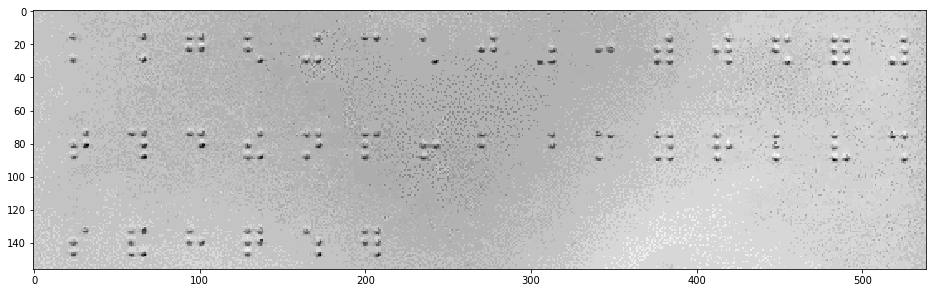

In [3]:
# extract zip file so program can be run in google colab 
zf.ZipFile('media.zip').extractall()

# filename of the input image
filename = "media/images/" + str(input()).rstrip() 
image = imageio.imread(filename)
matrix = np.array(image, copy=True, dtype=np.float)

N, M, _ = matrix.shape
  
sys.setrecursionlimit(10 * N * M)

# Plot original image
matrix = RGBtoGrayScale(matrix)
matrix = normalize(matrix)
mat = matrix.astype(np.uint8)
printNormalizedImage(mat)

## 2. Image segmentation

The second step tries to differentiate the braille circles of the background, using image segmentation.
The techniques applied here were



1.   Enhance pixels that has more contrast with neighbours , 
2.   Thresholding algorithm to transform image to binary matrix
3.   Binary erosion, to remove remaining noise and open braille circles



### Generating binary matrix

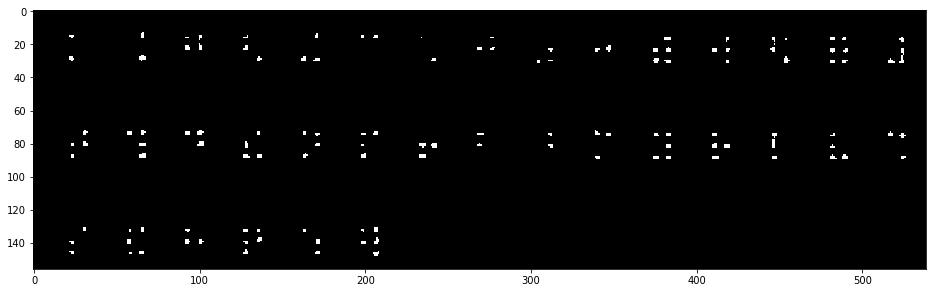

In [4]:
dots_matrix = Filter(matrix, 21) # Applies filter to normalized matrix
dots_matrix = normalize(dots_matrix)

# Smooth image using mean filter, to reduce noise
dots_matrix = MeanFilter(dots_matrix, 3)

# Thresholding step, 30 is arbitrary value derived from testing with images, but independent of input image gray scale
dots_matrix = ThresholdFilter(dots_matrix, 30)


# Erode the regions to calculate circles
dots_matrix = ndimage.binary_erosion(dots_matrix)

# Plot segmented image
mat = dots_matrix.astype(np.uint8)
printImage(mat)

### Function declarations

In [0]:
# Finds points of the image which are in a connected component 
def pointsInComponent(matrix, i, j, pts):
	vis[i, j] = 1
	pts.append((i, j))
	if i + 1 < N and vis[i+1, j] == 0 and matrix[i+1, j] == 1: pointsInComponent(matrix, i+1, j, pts)
	if i - 1 >=0 and vis[i-1, j] == 0 and matrix[i-1, j] == 1: pointsInComponent(matrix, i-1, j, pts)
	if j + 1 < M and vis[i, j+1] == 0 and matrix[i, j+1] == 1: pointsInComponent(matrix, i, j+1, pts)
	if j - 1 >=0 and vis[i, j-1] == 0 and matrix[i, j-1] == 1: pointsInComponent(matrix, i, j-1, pts)

# Flood fill algorithm to paint unwanted white regions
def paintBlack(matrix, i, j):
	matrix[i, j] = 0
	if i + 1 < N and matrix[i+1, j] == 1: paintBlack(matrix, i+1, j)
	if i - 1 >=0 and matrix[i-1, j] == 1: paintBlack(matrix, i-1, j)
	if j + 1 < M and matrix[i, j+1] == 1: paintBlack(matrix, i, j+1)
	if j - 1 >=0 and matrix[i, j-1] == 1: paintBlack(matrix, i, j-1)

# CV histogram correlation function
def compare(a, b):
	return cv2.compareHist(np.array(a).astype('float32'), np.array(b).astype('float32'), cv2.HISTCMP_CORREL)

# Euclidean distance comparison function
def euclideanDistance(a, b):
	return (np.sum((np.array(a) - np.array(b))**2)/256)**(1/2)


### Correcting unwanted white regions

Now we want to ignore some white regions, which must not be seen as braillee circles

To do that, we can use image description of our pattern, and use the comparison result to decide to keep or ignore some region 

The parameters that must be considered to describe the circles are the colour description, its size in pixels, and its centrality in the image

To describe our pattern, we can calculate the mean of the histograms, using centrality as a weight

Remove white regions that have euclidean distance too big or correlaction factor too small with our descriptor

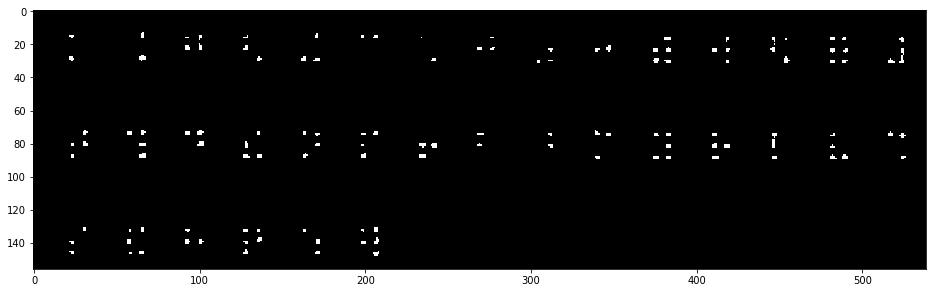

In [6]:
vis = np.zeros((N, M))

# Retrieve components (white regions) and its pixels
comp = []
for i in range(N):
	for j in range(M):
		if vis[i, j] == 0 and dots_matrix[i, j] == 1:
			comp.append([])
			pointsInComponent(dots_matrix, i, j, comp[-1])

# Calculate histograms of each region using list comprehension
histograms = [
	np.histogram(np.array([matrix[x] for x in pts]), bins=256, range=(0, 255))[0] 
	for pts in comp
]

sz = np.median([len(x) for x in comp])

# histogram description of braille circle, it is calculated as weighted mean of the histograms of white regions, in which the weight is it's centrality
desc = []

for c in range(256):
	desc.append(0)
	sum = 0 # sums of weights
	for i in range(len(comp)):
		if abs(len(comp[i]) - sz) > sz: continue 
		p, q = comp[i][0]
		w = np.min([(p+1), (N - p+1), (q+1), (M - q + 1)]) # weight of the region, its centrality
		w = w/(len(comp))
		sum += w
		desc[c] += w * histograms[i][c]
	desc[c] /= sum


errors = []
for i in range(len(histograms)):
	errors.append(compare(desc, histograms[i]))
	if compare(desc, histograms[i]) < 0 or euclideanDistance(desc, histograms[i]) > 1: #if correlation between the two histograms is less than 0.05, paint it black
		#print(euclideanDistance(desc, histograms[i]), end=' ')
		#print(compare(desc, histograms[i]))	
		paintBlack(dots_matrix, comp[i][0][0], comp[i][0][1])
    
# Plot segmented image
mat = dots_matrix.astype(np.uint8)
printImage(mat)


## 3. Determine diameter of a braille circle

To determine the average diameter of the braille circle, we can simply use the width and height of the bounding box of the white regions to the mean formula

In [7]:
# calculating the average diameter
diam = 0.0 
for i in range(len(comp)):
  if abs(len(comp[i]) - sz) > sz: continue 
  lo = N
  for pt in comp[i]: lo = min(lo, pt[0])
  hi = 0
  for pt in comp[i]: hi = max(hi, pt[0])

  v = hi - lo + 1
  lo = M
  for pt in comp[i]: lo = min(lo, pt[1])
  hi = 0
  for pt in comp[i]: hi = max(hi, pt[1])

  v = max(v, hi - lo + 1)
  diam += v

diam /= len(comp)
diam = round(diam)

print("Average diameter:", diam)

Average diameter: 3


## 4. Segment image into blocks and determine which letter it represents

This part of the program was implemented with two approaches:


*   Machine learning approach
*   Manual approach

In both ways, use sliding rectangle algorithm to determine position of the block

## Machine learning approach 
For this approach we used two algorithms already implemented in python libraries: Multi Layer Perceptron and Histogram Oriented Gradients. The steps taken were the following:
1. We manually created a dataset containing one labelled example image of each letter written in braille
2. To expand the dataset and use it for training the model, we applied some noise to the original images, generating 30 example images for each letter
3. Then we used 80% of these images to train a Multi Layer Perceptron model, using the Histogram of Oriented Gradients instead of the actual image. The other 20% was used to test the average accuracy of the classifier
4. After training the model, we were able to predict the letter shown, given the block of the braille symbol


In [8]:
# Function to apply noise and generate more training images
def gen_data(base_image, quantity, label, data, target, shift_value=4):
	for i in range(quantity):
		data.append(shift(base_image, [random.randint(-shift_value,shift_value), random.randint(-shift_value,shift_value)]))
		target.append(label)

# Reading train images
images = []
for i in range(1, 27):
	images.append(RGBtoGrayScale(imread("media/images/train/" + str(i) + ".png")))

X = []
Y = []

for i in range(26):
	gen_data(invert(images[i]), 30 , i+1, X, Y)

x = []

# set training set as hog vector of images
for i in X:
	x.append(hog(i, block_norm='L2-Hys',  pixels_per_cell=(2,2), visualize=False))

x = np.asarray(x)
y = np.asarray(Y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

# train model using 80% of generated images
clf = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=500, tol=1e-3)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Accuracy for labelled test dataset:", accuracy_score(y_test, y_pred))

Accuracy for labelled test dataset: 0.7628205128205128


In [0]:
# given an image block, determine which letter it represents using the trained model
def find_letter(img):
	resized = resize(img, (60,40))
	hog_img = hog(resized, block_norm='L2-Hys', pixels_per_cell=(2,2), visualize=False)
	letter = clf.predict([hog_img])
	return chr(ord('a') + letter-1)

letters_ml = []
wid = 4 * diam
hei = 6 * diam

copy_matrix = np.copy(dots_matrix)

for i in range(N):
	for j in range(M-1, -1, -1):
		if i-hei+1 < 0 or j+wid-1 >= M: continue
		tot = np.count_nonzero(copy_matrix[i-hei+1:i+1, j:j+wid])
		if tot == 0: continue

		## big rectangle
		tot2 = np.count_nonzero(copy_matrix[max(0, i-12*diam+1):min(i+6*diam+1, N), max(0, j-4*diam):min(M, j+8*diam)])
		offset = diam//2
		if tot2 == tot and i-hei+1 + offset >= 0 and i + 1 + offset <= N and j-offset >= 0 and j + wid - offset <= M:
			# pattern found, let's cut it
			pattern = copy_matrix[i-hei+1 + offset:i+1 + offset, j-offset:j+wid-offset]
			
			c = find_letter(pattern)

			letters_ml.append((i-hei+1, j, c))
			copy_matrix[i-hei+1:i+1, j:j+wid] = 0

### Manual approach

Segment each block further into six cells. Use average diameter of the circles as dimension of the cells, and python dictionary to translate vector of 0s and 1s to character

In [0]:
alphabet = {
  repr([1, 0, 0, 0, 0, 0]) : "a",\
  repr([1, 0, 1, 0, 0, 0]) : "b",\
  repr([1, 1, 0, 0, 0, 0]) : "c",\
  repr([1, 1, 0, 1, 0, 0]) : "d",\
  repr([1, 0, 0, 1, 0, 0]) : "e",\
  repr([1, 1, 1, 0, 0, 0]) : "f",\
  repr([1, 1, 1, 1, 0, 0]) : "g",\
  repr([1, 0, 1, 1, 0, 0]) : "h",\
  repr([0, 1, 1, 0, 0, 0]) : "i",\
  repr([0, 1, 1, 1, 0, 0]) : "j",\
  repr([1, 0, 0, 0, 1, 0]) : "k",\
  repr([1, 0, 1, 0, 1, 0]) : "l",\
  repr([1, 1, 0, 0, 1, 0]) : "m",\
  repr([1, 1, 0, 1, 1, 0]) : "n",\
  repr([1, 0, 0, 1, 1, 0]) : "o",\
  repr([1, 1, 1, 0, 1, 0]) : "p",\
  repr([1, 1, 1, 1, 1, 0]) : "q",\
  repr([1, 0, 1, 1, 1, 0]) : "r",\
  repr([0, 1, 1, 0, 1, 0]) : "s",\
  repr([0, 1, 1, 1, 1, 0]) : "t",\
  repr([1, 0, 0, 0, 1, 1]) : "u",\
  repr([1, 0, 1, 0, 1, 1]) : "v",\
  repr([0, 1, 1, 1, 0, 1]) : "w",\
  repr([1, 1, 0, 0, 1, 1]) : "x",\
  repr([1, 1, 0, 1, 1, 1]) : "y",\
  repr([1, 0, 0, 1, 1, 1]) : "z",\
}

In [0]:
# determine letter using manual approach
def find_letter(img):
	assert(img.shape == (hei, wid))
	vec = [0 for _ in range(6)]
	for k in range(6):
		i = k//2
		j = k%2
		tot = np.count_nonzero(img[i*2*diam:i*2*diam + 2*diam, j*2*diam:j*2*diam + 2*diam])
		vec[k] = 1 if tot > 0.2*diam*diam else 0

	if repr(vec) in alphabet: 
		return alphabet[repr(vec)]
	return '#'

letters_manual = []
wid = 4 * diam
hei = 6 * diam

copy_matrix = np.copy(dots_matrix)

for i in range(N):
	for j in range(M-1, -1, -1):
		if i-hei+1 < 0 or j+wid-1 >= M: continue
		tot = np.count_nonzero(copy_matrix[i-hei+1:i+1, j:j+wid])
		if tot == 0: continue

		## big rectangle
		tot2 = np.count_nonzero(copy_matrix[max(0, i-12*diam+1):min(i+6*diam+1, N), max(0, j-4*diam):min(M, j+8*diam)])
		offset = diam//2
		if tot2 == tot and i-hei+1 + offset >= 0 and i + 1 + offset <= N and j-offset >= 0 and j + wid - offset <= M:
			# We found a pattern, cut it
			pattern = copy_matrix[i-hei+1 + offset:i+1 + offset, j-offset:j+wid-offset]
			# print(pattern)
			c = find_letter(pattern)
			if c == '#' and i+offset + 2*diam < N:
				pattern = copy_matrix[i-hei+1 + offset + 2 * diam: i+1+offset + 2*diam, j-offset:j+wid-offset]
				c = find_letter(pattern)
			if c == '#' and i+offset + 4*diam < N:
				pattern = copy_matrix[i-hei+1 + offset + 4 * diam: i+1+offset + 4*diam, j-offset:j+wid-offset]
				c = find_letter(pattern)

			letters_manual.append((i-hei+1, j, c))
			copy_matrix[i-hei+1:i+1, j:j+wid] = 0

## 5. Insert corresponding letter on top of the block it represents

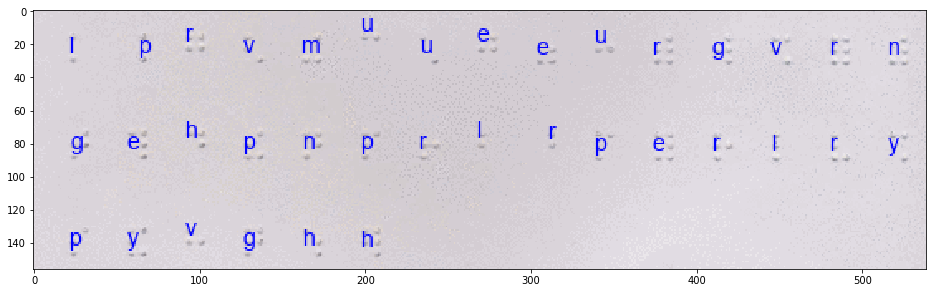

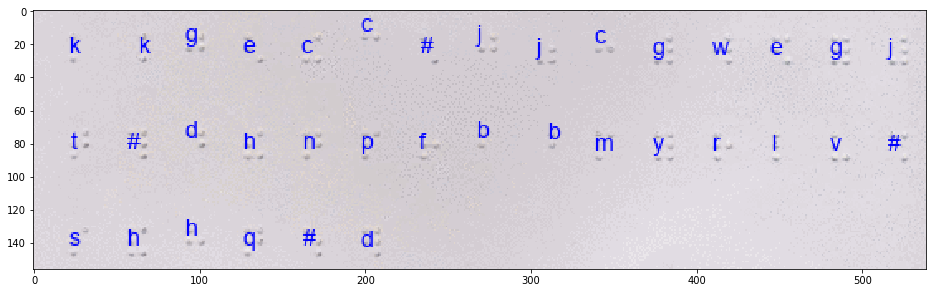

In [12]:
# Draws the letters on top of the boxes

# first the machine learning approach
img_ml = Image.open(filename).convert('RGBA')
d = ImageDraw.Draw(img_ml)
fnt = ImageFont.truetype('media/fonts/arial.ttf', 14)
for x, y, c in letters_ml:
	d.text((y, x), "" + c, font=fnt, fill=(0, 0, 255, 255))

plt.figure(figsize=(16,8))
plt.imshow(img_ml)
plt.show()

# then the manual approach
img_manual = Image.open(filename).convert('RGBA')
d = ImageDraw.Draw(img_manual)
for x, y, c in letters_manual:
	d.text((y, x), "" + c, font=fnt, fill=(0, 0, 255, 255))

plt.figure(figsize=(16,8))
plt.imshow(img_manual)
plt.show()